In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 20 17:32:00 2019

@author: Administrator
"""

import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
import math
from sklearn.cluster import KMeans
import time

In [2]:


######################################## 基本数据集加载  ########################################
data_path = './processed/'
print('基本数据集加载')
data = pd.read_csv(data_path + 'data_shenzhen.csv',parse_dates=['req_time','plan_time'])
profiles = pd.read_csv('../data/data_set_phase2/profiles.csv') 
print('完成加载')

########################################## 特征工程  ###########################################
print('特征工程')
########################################  经纬度特征  ##########################################
print('经纬度特征')
#1、曼哈顿距离特征：两点投影到各轴上的距离总和
data['o_lng'] = data['o'].apply(lambda x: float(x.split(',')[0]))
data['o_lat'] = data['o'].apply(lambda x: float(x.split(',')[1]))
data['d_lng'] = data['d'].apply(lambda x: float(x.split(',')[0]))
data['d_lat'] = data['d'].apply(lambda x: float(x.split(',')[1])) 
data['od_manhattan_distance'] = abs(data['o_lng']-data['d_lng'])+abs(data['o_lat']-data['d_lat'])

#2、直线距离特征：根据经纬度坐标计算两点间的直线距离
def GetDistance(lng1, lat1, lng2, lat2):
    #地球赤道半径6378.137km
    EARTH_RADIUS = 6378.137
    #把经纬度转换成度（°）
    lng1 = lng1 * (math.pi / 180.0)
    lng2 = lng2 * (math.pi / 180.0)
    lat1 = lat1 * (math.pi / 180.0)
    lat2 = lat2 * (math.pi / 180.0)

    dis1 = lat1 - lat2
    dis2 = lng1 - lng2
    #以1m为球的半径，求球上两点的距离
    s = 2 * math.asin(
        ((math.sin(dis1 / 2)) ** 2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dis2 / 2)) ** 2) ** 0.5)
    #换算成地球的半径：6378.137km *1000 = 6378137m
    s = s * EARTH_RADIUS * 1000
    return s
data['od_manhattan_distance_detail']=data.apply(lambda row:GetDistance(row['o_lng'],row['o_lat'],row['d_lng'],row['d_lat']),axis=1)


#3、始终点的经纬度分别与始终点的经纬度的平均值和众数的差之和
o_co = data[['o']]
d_co = data[['d']]

o_co.columns = ['co']
d_co.columns = ['co']

all_co = pd.concat([d_co, o_co]).drop_duplicates()
all_co['lng'] = all_co['co'].apply(lambda x: float(x.split(',')[0]))
all_co['lat'] = all_co['co'].apply(lambda x: float(x.split(',')[1]))
lng_mean = all_co['lng'].mean()
lat_mean = all_co['lat'].mean()

lng_mode = all_co['lng'].mode()[0]
lat_mode = all_co['lat'].mode()[0]
data['o_main_centroid_mean_dis'] = abs(
    data['o_lng']-lng_mean)+abs(data['o_lat']-lat_mean)
data['d_main_centroid_mean_dis'] = abs(
    data['d_lng']-lng_mean)+abs(data['d_lat']-lat_mean)

data['o_main_centroid_mode_dis'] = abs(
    data['o_lng']-lng_mode)+abs(data['o_lat']-lat_mode)
data['d_main_centroid_mode_dis'] = abs(
    data['d_lng']-lng_mode)+abs(data['d_lat']-lat_mode)

#4、所有地点的经纬度聚类
data['o_cluster', 'd_cluster'] = np.nan
clf_KMeans = KMeans(n_clusters=11)#构造聚类器
cluster = clf_KMeans.fit_predict(all_co[['lng','lat']])#聚类
index = 0
for co in tqdm(all_co['co']):
    #所有地点的经纬度聚类
    data.loc[(data['o'] == co), 'o_cluster'] = cluster[index]
    data.loc[(data['d'] == co), 'd_cluster'] = cluster[index]
    index +=1

od_feature = ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']
print('经纬度特征数量：', len(od_feature), od_feature) 

基本数据集加载


KeyboardInterrupt: 

In [2]:
########################################  距离特征  ##########################################
print('距离特征')
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1.0 / p)    

def calculate_direction(d_lon, d_lat):  
    result = np.zeros(len(d_lon))   
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])   
    return result

def add_travel_vector_features(df):    
    df['delta_longitude'] = df.o_lng - df.d_lng
    df['delta_latitude'] = df.o_lat - df.d_lat   
    df['pickup_x'] = np.cos(df.o_lat) * np.cos(df.o_lng)
    df['pickup_y'] = np.cos(df.o_lat) * np.sin(df.o_lng)
    df['pickup_z'] = np.sin(df.o_lat)   
    df['dropoff_x'] = np.cos(df.d_lat) * np.cos(df.d_lng)
    df['dropoff_y'] = np.cos(df.d_lat) * np.sin(df.d_lng)
    df['dropoff_z'] = np.sin(df.d_lat)

data['manhattan'] = minkowski_distance(data.o_lng, data.d_lng, 
                                           data.o_lat, data.d_lat, 1)
data['euclidean']=minkowski_distance(data.o_lng, data.d_lng, 
                                           data.o_lat, data.d_lat, 2)

add_travel_vector_features(data)
data['direction'] = calculate_direction(data.delta_longitude, data.delta_latitude)

distance_feature = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']
print('距离特征数量：', len(distance_feature), distance_feature) 

################################  plan_time & req_time特征  ###################################
print('plan_time & req_time特征') 
#1、原始时间特征上的处理
data['req_time_hour'] = data['req_time'].dt.hour
data['req_time_weekday'] = data['req_time'].dt.weekday
data['req_time_minute'] = data['req_time'].dt.minute
data['req_time_date_d'] = data['req_time'].dt.strftime('%d').astype(int)

    
#2、时差特征
data['time_diff'] = (data['plan_time']- data['req_time']).dt.seconds

#3、请求的时间点与当天早上6点、中午12点、下午6点、晚上6点的分钟差距
def diff_6_clock(time_point):
    six_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(6)+':0:00'
    six_clock=pd.to_datetime(six_clock)
    the_diff=(six_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_12_clock(time_point):
    t12_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(12)+':0:00'
    t12_clock=pd.to_datetime(t12_clock)
    the_diff=(t12_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_18_clock(time_point):
    t18_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(18)+':0:00'
    t18_clock=pd.to_datetime(t18_clock)
    the_diff=(t18_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_24_clock(time_point):
    t24_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(23)+':59:00'
    t24_clock=pd.to_datetime(t24_clock)
    the_diff=(t24_clock- time_point).total_seconds()
    return abs(the_diff/60)

data['diff_6_cloc']=data['req_time'].apply(diff_6_clock)
data['diff_12_clock']=data['req_time'].apply(diff_12_clock)
data['diff_18_clock']=data['req_time'].apply(diff_18_clock)
data['diff_24_clock']=data['req_time'].apply(diff_24_clock)

time_feature = ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 
                'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
print('plan_time & req_time特征数量：', len(time_feature),time_feature)

################################  对profile的降维提取特征  ###################################
print('对profile的降维提取特征') 
x = profiles.drop(['pid'], axis=1).values
svd = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
svd_x = svd.fit_transform(x)
svd_feas = pd.DataFrame(svd_x)
svd_feas.columns = ['svd_fea_{}'.format(i) for i in range(10)]
svd_feas['pid'] = profiles['pid'].values
data = data.merge(svd_feas, on='pid', how='left')

profiles_svd_feature = ['svd_fea_{}'.format(i) for i in range(10)]
print('对profile的降维提取特征完成数量：', len(profiles_svd_feature), profiles_svd_feature) 

##############################  plans百度地图推荐交通方式特征  #################################
# ### plans百度地图推荐特征
#    
#      此处特征包括：
#      *Plans中针对这次导航任务，百度地图所提供的路线选择:12
#      *提供的路线选择中距离、价格和所花时间的最大值、最小值、均值、方差:12
#      *提供的路线选择中距离最大和最小、价格最高和最低、所花时间最多和最少的交通方式:6
#      *提供的路线选择中的第一种交通方式:1
#      *模式数据压缩:10
print('plans百度地图推荐交通方式特征') 
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode =     np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            first_mode[i]                = mode_list[0]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
    feature_data                   =  pd.DataFrame(mode_list_feas)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist
    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price
    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta
    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    return plan_fea

data_plans = gen_plan_feas(data)
data = data.merge(data_plans, on='sid', how='left')

plan_feature = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 
               'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 
               'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']
print('plans百度地图推荐交通方式特征数量：', len(plan_feature), plan_feature) 


距离特征
距离特征数量： 11 ['manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction']
plan_time & req_time特征
plan_time & req_time特征数量： 9 ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
对profile的降维提取特征
对profile的降维提取特征完成数量： 10 ['svd_fea_0', 'svd_fea_1', 'svd_fea_2', 'svd_fea_3', 'svd_fea_4', 'svd_fea_5', 'svd_fea_6', 'svd_fea_7', 'svd_fea_8', 'svd_fea_9']
plans百度地图推荐交通方式特征


555523it [01:14, 7485.73it/s]


mode tfidf...
plans百度地图推荐交通方式特征数量： 41 ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']


In [3]:
##############################  plan推荐mode平铺特征  #################################
print('plan推荐mode平铺特征')
#对plans内的信息直接进行平铺，平铺时求取每个mode的距离、price、eta，根据mode在plan中出现的次序给出排名信息。这样就构建了11*4个特征
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_pingpu_feas(data):  
    #创建用于放置mode平均距离、平均价格、平均eta、出现位置排名,共11个模式的11*4个特征 （为0的模式就不做标识了） 添加model所属的工具模态
    n                                           = data.shape[0]
    #mode_list_feas                              = np.zeros((n, 12))
    model_1_dist,model_1_price,model_1_eta,model_1_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_2_dist,model_2_price,model_2_eta,model_2_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_3_dist,model_3_price,model_3_eta,model_3_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_4_dist,model_4_price,model_4_eta,model_4_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_5_dist,model_5_price,model_5_eta,model_5_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_6_dist,model_6_price,model_6_eta,model_6_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_7_dist,model_7_price,model_7_eta,model_7_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_8_dist,model_8_price,model_8_eta,model_8_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_9_dist,model_9_price,model_9_eta,model_9_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_10_dist,model_10_price,model_10_eta,model_10_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_11_dist,model_11_price,model_11_eta,model_11_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    n=0
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            model_1_dist[i]=-1
            model_1_price[i]=-1
            model_1_eta[i]=-1
            model_1_rank[i]=-1
            model_2_dist[i]=-1
            model_2_price[i]=-1
            model_2_eta[i]=-1
            model_2_rank[i]=-1
            model_3_dist[i]=-1
            model_3_price[i]=-1
            model_3_eta[i]=-1
            model_3_rank[i]=-1
            model_4_dist[i]=-1
            model_4_price[i]=-1
            model_4_eta[i]=-1
            model_4_rank[i]=-1
            model_5_dist[i]=-1
            model_5_price[i]=-1
            model_5_eta[i]=-1
            model_5_rank[i]=-1
            model_6_dist[i]=-1
            model_6_price[i]=-1
            model_6_eta[i]=-1
            model_6_rank[i]=-1
            model_7_dist[i]=-1
            model_7_price[i]=-1
            model_7_eta[i]=-1
            model_7_rank[i]=-1
            model_8_dist[i]=-1
            model_8_price[i]=-1
            model_8_eta[i]=-1
            model_8_rank[i]=-1
            model_9_dist[i]=-1
            model_9_price[i]=-1
            model_9_eta[i]=-1
            model_9_rank[i]=-1
            model_10_dist[i]=-1
            model_10_price[i]=-1
            model_10_eta[i]=-1
            model_10_rank[i]=-1
            model_11_dist[i]=-1
            model_11_price[i]=-1
            model_11_eta[i]=-1
            model_11_rank[i]=-1
        else:
            
            model_1_dist_list=[]
            model_1_price_list=[]
            model_1_eta_list=[]
            model_1_rank_list=[]
            model_2_dist_list=[]
            model_2_price_list=[]
            model_2_eta_list=[]
            model_2_rank_list=[]
            model_3_dist_list=[]
            model_3_price_list=[]
            model_3_eta_list=[]
            model_3_rank_list=[]
            model_4_dist_list=[]
            model_4_price_list=[]
            model_4_eta_list=[]
            model_4_rank_list=[]
            model_5_dist_list=[]
            model_5_price_list=[]
            model_5_eta_list=[]
            model_5_rank_list=[]
            model_6_dist_list=[]
            model_6_price_list=[]
            model_6_eta_list=[]
            model_6_rank_list=[]
            model_7_dist_list=[]
            model_7_price_list=[]
            model_7_eta_list=[]
            model_7_rank_list=[]
            model_8_dist_list=[]
            model_8_price_list=[]
            model_8_eta_list=[]
            model_8_rank_list=[]
            model_9_dist_list=[]
            model_9_price_list=[]
            model_9_eta_list=[]
            model_9_rank_list=[]
            model_10_dist_list=[]
            model_10_price_list=[]
            model_10_eta_list=[]
            model_10_rank_list=[]
            model_11_dist_list=[]
            model_11_price_list=[]
            model_11_eta_list=[]
            model_11_rank_list=[]

            mode_list = []
            for tmp_dit in cur_plan_list:
                if tmp_dit['price'] == '':
                    tmp_dit['price']=0
                if tmp_dit['transport_mode']==1:
                    model_1_dist_list.append(int(tmp_dit['distance']))
                    model_1_price_list.append(int(tmp_dit['price']))
                    model_1_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==2:
                    model_2_dist_list.append(int(tmp_dit['distance']))
                    model_2_price_list.append(int(tmp_dit['price']))
                    model_2_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==3:
                    model_3_dist_list.append(int(tmp_dit['distance']))
                    model_3_price_list.append(int(tmp_dit['price']))
                    model_3_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==4:
                    model_4_dist_list.append(int(tmp_dit['distance']))
                    model_4_price_list.append(int(tmp_dit['price']))
                    model_4_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==5:
                    model_5_dist_list.append(int(tmp_dit['distance']))
                    model_5_price_list.append(int(tmp_dit['price']))
                    model_5_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==6:
                    model_6_dist_list.append(int(tmp_dit['distance']))
                    model_6_price_list.append(int(tmp_dit['price']))
                    model_6_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==7:
                    model_7_dist_list.append(int(tmp_dit['distance']))
                    model_7_price_list.append(int(tmp_dit['price']))
                    model_7_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==8:
                    model_8_dist_list.append(int(tmp_dit['distance']))
                    model_8_price_list.append(int(tmp_dit['price']))
                    model_8_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==9:
                    model_9_dist_list.append(int(tmp_dit['distance']))
                    model_9_price_list.append(int(tmp_dit['price']))
                    model_9_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==10:
                    model_10_dist_list.append(int(tmp_dit['distance']))
                    model_10_price_list.append(int(tmp_dit['price']))
                    model_10_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==11:
                    model_11_dist_list.append(int(tmp_dit['distance']))
                    model_11_price_list.append(int(tmp_dit['price']))
                    model_11_eta_list.append(int(tmp_dit['eta']))
                                             
                mode_list.append(int(tmp_dit['transport_mode']))
            
            
            
            mode_list.extend([1,2,3,4,5,6,7,8,9,10,11])        
            mode_list_end  =len(mode_list)-11
                                             
            model_1_dist[i]=np.mean(model_1_dist_list)
            model_1_price[i]=np.mean(model_1_price_list)
            model_1_eta[i]=np.mean(model_1_eta_list)
            if mode_list.index(1)<mode_list_end:
                model_1_rank[i]=mode_list.index(1)
            else:
                model_1_rank[i]=-1   
                                             
            model_2_dist[i]=np.mean(model_2_dist_list)                  
            model_2_price[i]=np.mean(model_2_price_list)
            model_2_eta[i]=np.mean(model_2_eta_list)
            if mode_list.index(2)<mode_list_end:
                model_2_rank[i]=mode_list.index(2)
            else:
                model_2_rank[i]=-1   
                                                              
            model_3_dist[i]=np.mean(model_3_dist_list)
            model_3_price[i]=np.mean(model_3_price_list)
            model_3_eta[i]=np.mean(model_3_eta_list)
            if mode_list.index(3)<mode_list_end:
                model_3_rank[i]=mode_list.index(3)
            else:
                model_3_rank[i]=-1   
                                                              
            model_4_dist[i]=np.mean(model_4_dist_list)
            model_4_price[i]=np.mean(model_4_price_list)
            model_4_eta[i]=np.mean(model_4_eta_list)
            if mode_list.index(4)<mode_list_end:
                model_4_rank[i]=mode_list.index(4)
            else:
                model_4_rank[i]=-1   
                                                              
            model_5_dist[i]=np.mean(model_5_dist_list)
            model_5_price[i]=np.mean(model_5_price_list)
            model_5_eta[i]=np.mean(model_5_eta_list)
            if mode_list.index(5)<mode_list_end:
                model_5_rank[i]=mode_list.index(5)
            else:
                model_5_rank[i]=-1   
                                                              
            model_6_dist[i]=np.mean(model_6_dist_list)
            model_6_price[i]=np.mean(model_6_price_list)
            model_6_eta[i]=np.mean(model_6_eta_list)
            if mode_list.index(6)<mode_list_end:
                model_6_rank[i]=mode_list.index(6)
            else:
                model_6_rank[i]=-1   
                                                              
            model_7_dist[i]=np.mean(model_7_dist_list)
            model_7_price[i]=np.mean(model_7_price_list)
            model_7_eta[i]=np.mean(model_7_eta_list)
            if mode_list.index(7)<mode_list_end:
                model_7_rank[i]=mode_list.index(7)
            else:
                model_7_rank[i]=-1   
                                                              
            model_8_dist[i]=np.mean(model_8_dist_list)
            model_8_price[i]=np.mean(model_8_price_list)
            model_8_eta[i]=np.mean(model_8_eta_list)
            if mode_list.index(8)<mode_list_end:
                model_8_rank[i]=mode_list.index(8)
            else:
                model_8_rank[i]=-1   
                                                              
            model_9_dist[i]=np.mean(model_9_dist_list)
            model_9_price[i]=np.mean(model_9_price_list)
            model_9_eta[i]=np.mean(model_9_eta_list)
            if mode_list.index(9)<mode_list_end:
                model_9_rank[i]=mode_list.index(8)
            else:
                model_9_rank[i]=-1   
                                                              
            model_10_dist[i]=np.mean(model_10_dist_list)
            model_10_price[i]=np.mean(model_10_price_list)
            model_10_eta[i]=np.mean(model_10_eta_list)
            if mode_list.index(10)<mode_list_end:
                model_10_rank[i]=mode_list.index(10)
            else:
                model_10_rank[i]=-1   
                                                              
            model_11_dist[i]=np.mean(model_11_dist_list)
            model_11_price[i]=np.mean(model_11_price_list)
            model_11_eta[i]=np.mean(model_11_eta_list)
            if mode_list.index(11)<mode_list_end:
                model_11_rank[i]=mode_list.index(11)
            else:
                model_11_rank[i]=-1   
                                             
                                             
    feature_data =  pd.DataFrame()  
    feature_data['plan_model_1_dist']    =  model_1_dist
    feature_data['plan_model_1_price']    =  model_1_price                      
    feature_data['plan_model_1_eta']    =  model_1_eta     
    feature_data['plan_model_1_rank']    =  model_1_rank 
                                             
    feature_data['plan_model_2_dist']    =  model_2_dist
    feature_data['plan_model_2_price']    =  model_2_price                      
    feature_data['plan_model_2_eta']    =  model_2_eta     
    feature_data['plan_model_2_rank']    =  model_2_rank                                             

    feature_data['plan_model_3_dist']    =  model_3_dist
    feature_data['plan_model_3_price']    =  model_3_price                      
    feature_data['plan_model_3_eta']    =  model_3_eta     
    feature_data['plan_model_3_rank']    =  model_3_rank

    feature_data['plan_model_4_dist']    =  model_4_dist
    feature_data['plan_model_4_price']    =  model_4_price                      
    feature_data['plan_model_4_eta']    =  model_4_eta     
    feature_data['plan_model_4_rank']    =  model_4_rank
                                        
    feature_data['plan_model_5_dist']    =  model_5_dist
    feature_data['plan_model_5_price']    =  model_5_price                      
    feature_data['plan_model_5_eta']    =  model_5_eta     
    feature_data['plan_model_5_rank']    =  model_5_rank
                                             
    feature_data['plan_model_6_dist']    =  model_6_dist
    feature_data['plan_model_6_price']    =  model_6_price                      
    feature_data['plan_model_6_eta']    =  model_6_eta     
    feature_data['plan_model_6_rank']    =  model_6_rank
                                            
    feature_data['plan_model_7_dist']    =  model_7_dist
    feature_data['plan_model_7_price']    =  model_7_price                      
    feature_data['plan_model_7_eta']    =  model_7_eta     
    feature_data['plan_model_7_rank']    =  model_7_rank
                                             
    feature_data['plan_model_8_dist']    =  model_8_dist
    feature_data['plan_model_8_price']    =  model_8_price                      
    feature_data['plan_model_8_eta']    =  model_8_eta     
    feature_data['plan_model_8_rank']    =  model_8_rank
                                             
    feature_data['plan_model_9_dist']    =  model_9_dist
    feature_data['plan_model_9_price']    =  model_9_price                      
    feature_data['plan_model_9_eta']    =  model_9_eta     
    feature_data['plan_model_9_rank']    =  model_9_rank
                                             
    feature_data['plan_model_10_dist']    =  model_10_dist
    feature_data['plan_model_10_price']    =  model_10_price                      
    feature_data['plan_model_10_eta']    =  model_10_eta     
    feature_data['plan_model_10_rank']    =  model_10_rank   

    feature_data['plan_model_11_dist']    =  model_11_dist
    feature_data['plan_model_11_price']    =  model_11_price                      
    feature_data['plan_model_11_eta']    =  model_11_eta     
    feature_data['plan_model_11_rank']    =  model_11_rank                                         
    return feature_data

new_df=gen_plan_pingpu_feas(data)
data = pd.concat([data,new_df],axis=1)
pingpu_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingpu_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingpu_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingpu_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]

plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_eta_feature+pingpu_rank_feature
print('plan推荐mode平铺特征数量：', len(plan_pingpu_feature), plan_pingpu_feature) 

##############################  位置点和od对出现次数及排序特征  #################################
print('位置点和od对出现次数及排序特征')
#统计位置点出现的次数，并对次数进行大小的排序
#对地点出现次数进行排序，统计那些经常是导航起点的位置
o_appear_count=list(data.groupby(by=['o']).size())
d_appear_count=list(data.groupby(by=['d']).size())

the_query_o_count_df=pd.DataFrame()
the_query_d_count_df=pd.DataFrame()

o_list=[]
for name,group in data.groupby(by=['o']):
    o_list.append(name)
    
d_list=[]
for name,group in data.groupby(by=['d']):
    d_list.append(name)
    
the_query_o_count_df['o']=o_list
the_query_d_count_df['d']=d_list
the_query_o_count_df['o_appear_count']=o_appear_count
the_query_d_count_df['d_appear_count']=d_appear_count

data=data.merge(the_query_o_count_df, 'left', ['o']) 
data=data.merge(the_query_d_count_df, 'left', ['d']) 

data['o_appear_count_rank'] = data['o_appear_count'].rank() / float(data.shape[0])
data['d_appear_count_rank'] = data['d_appear_count'].rank() / float(data.shape[0])
data['o_appear_count_rank_buguiyi'] = data['o_appear_count'].rank() 
data['d_appear_count_rank_buguiyi'] = data['d_appear_count'].rank() 

#od共同出现情况及排序
#构建od对出现次数 统计特征，并对该特征进行排序，尝试效果。
data['od_couple']=data.apply(lambda row:(row['o']+'_'+row['d']),axis=1) 

od_appear_count=list(data.groupby(by=['od_couple']).size())

the_query_od_count_df=pd.DataFrame()

od_list=[]
for name,group in data.groupby(by=['od_couple']):
    od_list.append(name)
    
the_query_od_count_df['od_couple']=od_list
the_query_od_count_df['od_couple_count']=od_appear_count

data=data.merge(the_query_od_count_df, 'left', ['od_couple']) 
data['od_couple_rank'] = data['od_couple_count'].rank() / float(data.shape[0])
data['od_couple_rank_buguiyi'] = data['od_couple_count'].rank() 

od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple','od_couple_count','od_couple_rank','od_couple_rank_buguiyi']
print('位置点和od对出现次数及排序特征数量：', len(od_appear_feature), od_appear_feature) 

#########################  对plan_mode中的dis、eta、price和rank进行排序特征  ###########################
print('对plan_mode中的dis、eta、price和rank进行排序特征')
#第二波排序特征， 对平展后的每个特征进行整体的排序
for i in range(1,12):
    data['plan_model_'+str(i)+'_dist'+'_rank']=data['plan_model_'+str(i)+'_dist'].rank() 
    data['plan_model_'+str(i)+'_eta'+'_rank']=data['plan_model_'+str(i)+'_eta'].rank()    
    data['plan_model_'+str(i)+'_price'+'_rank']=data['plan_model_'+str(i)+'_price'].rank() 
    data['plan_model_'+str(i)+'_rank'+'_rank']=data['plan_model_'+str(i)+'_rank'].rank() 
    
    data['plan_model_'+str(i)+'_dist'+'_rank_guiyi']=data['plan_model_'+str(i)+'_dist'].rank()  / float(data.shape[0])
    data['plan_model_'+str(i)+'_eta'+'_rank_guiyi']=data['plan_model_'+str(i)+'_eta'].rank()  / float(data.shape[0])   
    data['plan_model_'+str(i)+'_price'+'_rank_guiyi']=data['plan_model_'+str(i)+'_price'].rank()  / float(data.shape[0])
    data['plan_model_'+str(i)+'_rank'+'_rank_guiyi']=data['plan_model_'+str(i)+'_rank'].rank()  / float(data.shape[0])

pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

pingzhan_dist_rank_guiyi_feature=['plan_model_'+str(i)+'_dist'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_price_rank_guiyi_feature=['plan_model_'+str(i)+'_eta'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_eta_rank_guiyi_feature=['plan_model_'+str(i)+'_price'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_rank_rank_guiyi_feature=['plan_model_'+str(i)+'_rank'+'_rank_guiyi'  for i in range(1,12)]

plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature+pingzhan_dist_rank_guiyi_feature+pingzhan_price_rank_guiyi_feature+pingzhan_eta_rank_guiyi_feature+pingzhan_rank_rank_guiyi_feature
print('对plan_mode中的dis、eta、price和rank进行排序特征数量：', len(plan_pingzhan_rank_feature), plan_pingzhan_rank_feature) 


plan推荐mode平铺特征


555523it [03:37, 2550.16it/s]


plan推荐mode平铺特征数量： 44 ['plan_model_1_dist', 'plan_model_2_dist', 'plan_model_3_dist', 'plan_model_4_dist', 'plan_model_5_dist', 'plan_model_6_dist', 'plan_model_7_dist', 'plan_model_8_dist', 'plan_model_9_dist', 'plan_model_10_dist', 'plan_model_11_dist', 'plan_model_1_price', 'plan_model_2_price', 'plan_model_3_price', 'plan_model_4_price', 'plan_model_5_price', 'plan_model_6_price', 'plan_model_7_price', 'plan_model_8_price', 'plan_model_9_price', 'plan_model_10_price', 'plan_model_11_price', 'plan_model_1_eta', 'plan_model_2_eta', 'plan_model_3_eta', 'plan_model_4_eta', 'plan_model_5_eta', 'plan_model_6_eta', 'plan_model_7_eta', 'plan_model_8_eta', 'plan_model_9_eta', 'plan_model_10_eta', 'plan_model_11_eta', 'plan_model_1_rank', 'plan_model_2_rank', 'plan_model_3_rank', 'plan_model_4_rank', 'plan_model_5_rank', 'plan_model_6_rank', 'plan_model_7_rank', 'plan_model_8_rank', 'plan_model_9_rank', 'plan_model_10_rank', 'plan_model_11_rank']
位置点和od对出现次数及排序特征
位置点和od对出现次数及排序特征数量： 10 ['o_ap

In [9]:
data.shape


(555523, 272)

# 直接使用过往的数据

In [3]:
data=pd.read_csv('shenzhen_version3_2019-06-11_16_20_all_features.csv',parse_dates=['req_time','plan_time']) 

In [4]:
len(data)

555523

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,20555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,42213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29526,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,117756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,185606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,13621,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,42552,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,119278,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,181749,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,103887,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 加入地点所属区标识。

In [24]:
address_all_info_area_fill=pd.read_csv('./address_all_info_area_fill.csv')

In [25]:

address_all_info_final_filter=address_all_info_area_fill[['address','after_deal_area']]
address_all_info_final_o=address_all_info_final_filter.rename(columns={'address':'o','after_deal_area':'area_o'})
address_all_info_final_d=address_all_info_final_filter.rename(columns={'address':'d','after_deal_area':'area_d'})

data = data.merge(address_all_info_final_o, on=['o'], how='left')
data = data.merge(address_all_info_final_d, on=['d'], how='left')

In [27]:
data.columns.values

array(['click_mode', 'd', 'o', 'pid', 'plan_time', 'plans', 'req_time',
       'sid', 'o_lng', 'o_lat', 'd_lng', 'd_lat', 'city_flag_o',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y',
       'dropoff_z', 'direction', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'diff_6_cloc',
       'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2', 'svd_fea_3', 'svd_fea_4', 'svd_fea_5',
       'svd_fea_6', 'svd_fea_7', 'svd_fea_8', 'svd_fea_9', 'plans_json',
       'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3',
       'mode_feas_4', 'mode_feas_5', 'mode_fe

In [28]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(data['area_o_x'])
data['area_o_label']=le.transform(data['area_o_x'])

le.fit(data['area_d_x'])
data['area_d_label']=le.transform(data['area_d_x'])

In [29]:
data['area_o_d_conn']=data['area_o_x']+data['area_d_x']
le.fit(data['area_o_d_conn'])
data['area_o_d_conn_label']=le.transform(data['area_o_d_conn'])

# 队友给的FM和cos距离特征

In [ ]:
# add feat
def cal_cos_dis(temp1, temp2):
    temp1 = temp1.values
    temp2 = temp2.values
    dot = np.sum(temp1 * temp2, axis=1)
    # print(dot)
    norm = np.sqrt(np.sum(temp1 * temp1, axis=1)) * np.sqrt(np.sum(temp2 * temp2, axis=1))
    return dot / norm, dot, norm


def cal_pearson_dist(temp1, temp2):
    e1 = np.mean(temp1, axis=1)
    e2 = np.mean(temp2, axis=1)
    # if (e1 == -1) | (e2 == -1):
    #     return 0
    e12 = np.mean(temp1 * temp2, axis=1)
    e11 = np.mean(temp1 * temp1, axis=1)
    e22 = np.mean(temp2 * temp2, axis=1)
    return (e12 - e1 * e2) / (np.sqrt(e11 - e1 * e1) * np.sqrt(e22 - e2 * e2) + 1e-8)


def add_cos_dis(data):
    dist_feat = ['plan_model_%d_dist' % i for i in range(1, 12)]
    price_feat = ['plan_model_%d_price' % i for i in range(1, 12)]
    eta_feat = ['plan_model_%d_eta' % i for i in range(1, 12)]

    plans = data[dist_feat + price_feat + eta_feat]
    plans = plans.fillna(-1)
    # 609792 6098120977899495
    plans[plans==-1] = 99999999
    k = 0
    for i in range(1, 12):
        temp1 = plans[['plan_model_%d_dist' % i, 'plan_model_%d_price' % i, 'plan_model_%d_eta' % i]]
        data['norm_%d_plan_i' % i] = np.sqrt(np.sum(np.power(temp1, 2), axis=1))

        for j in range(i+1, 12):
            # 向量的基本运算都用上?
            temp2 = plans[['plan_model_%d_dist' % j, 'plan_model_%d_price' % j, 'plan_model_%d_eta' % j]]
            cos, dot, norm = cal_cos_dis(temp1, temp2)
            # 660943
            data['cos_%d_plan' % k] = cos

            # 660834
            # data['dot_%d_plan' % k] = dot
            # data['norm_%d_plan' % k] = norm

            # data['norm_%d_plan_add' % k] = np.sqrt(np.sum(np.power(temp1 + temp2, 2), axis=1))
            # data['norm_%d_plan_sub' % k] = np.sqrt(np.sum(np.power(temp1 - temp2, 2), axis=1))

            data['manha_%d_plan' % k] = np.sum(np.abs(temp1 - temp2), axis=1)
            #data['cheby_%d_plan' % k] = np.max(np.abs(temp1 - temp2), axis=1)
            #data['tani_%d_plan' % k] = dot / (np.sum(temp1 * temp1, axis=1) + np.sum(temp2 * temp2, axis=1) - dot)
            # data['pearson_%d_plan' % k] = cal_pearson_dist(temp1, temp2)

            k += 1
    print(data['cos_%d_plan' % 0])
    print(np.sum(np.array(data['cos_%d_plan' % 0].values, np.int) == 1))

    return data

In [49]:
start_timestamp=np.min(mode_0_data['req_time'])
type(start_timestamp)

str

### 对o、d、hour分组  下的 mode的产生次数计数

In [22]:
col = ['o','d','req_time_hour']

train_index = (data.req_time < '2018-11-23') 
train_o_d_req_data     = data[train_index][['o','d','req_time_hour','click_mode']]
print(len(train_o_d_req_data))
mode_count = train_o_d_req_data.groupby(col)['click_mode'].value_counts(normalize=True).unstack()  #进行mode 的计数的是时候，也进行了归一化，反正有的过大
print(len(mode_count))
mode_count.columns = ['o_d_hour_count_mode_count_'+str(i) for i in range(0,12)]
#，产生不好的影响
mode_count['max_o_d_hour_count_mode'] = mode_count.idxmax(axis=1)
print(len(mode_count))
train_o_d_req_data = train_o_d_req_data.merge(mode_count, on=col, how='left')
print(train_o_d_req_data)
print(len(data))
temp_df=mode_count

#print(temp_df)
merge=data.merge(temp_df, how='left', on=['o','d','req_time_hour']) 
print(len(merge))

439453
305802
305802
                   o             d  req_time_hour  click_mode  \
0       114.12,22.55  114.09,22.57             18         1.0   
1       113.84,22.81  113.84,22.80             14         5.0   
2       113.98,22.54  114.32,22.61             22         0.0   
3       113.84,22.62  114.06,22.52             15         3.0   
4       113.90,22.57  114.00,22.61             18         9.0   
5       113.98,22.54  113.81,22.64             20         2.0   
6       114.05,22.63  113.80,22.75             18         7.0   
7       114.09,22.57  113.92,22.53             21         2.0   
8       114.11,22.54  114.30,22.60             20         0.0   
9       114.07,22.63  114.03,22.61             14         2.0   
10      113.92,22.65  114.08,22.54             21        10.0   
11      114.06,22.54  113.91,22.48             16         2.0   
12      114.11,22.53  113.94,22.59             23         0.0   
13      114.05,22.54  114.05,22.54             10         5.0   
14  

[439453 rows x 17 columns]
555523
555523


In [24]:
data=merge

In [25]:
data['max_o_d_hour_count_mode'].value_counts()


o_d_hour_count_mode_count_0     176287
o_d_hour_count_mode_count_2      79156
o_d_hour_count_mode_count_1      67683
o_d_hour_count_mode_count_5      45569
o_d_hour_count_mode_count_7      44847
o_d_hour_count_mode_count_9      29195
o_d_hour_count_mode_count_3      12010
o_d_hour_count_mode_count_10      7691
o_d_hour_count_mode_count_4       6437
o_d_hour_count_mode_count_11      5723
o_d_hour_count_mode_count_6       4172
o_d_hour_count_mode_count_8       1354
Name: max_o_d_hour_count_mode, dtype: int64

In [26]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#data['max_o_d_hour_count_mode'].fillna('o_d_hour_count_mode_count_-1')

le.fit(data['max_o_d_hour_count_mode'].astype(str))
data['max_o_d_hour_count_mode']=le.transform(data['max_o_d_hour_count_mode'].astype(str))

In [14]:
data

,click_mode,d,o,pid,plan_time,plans,req_time,sid,o_lng,o_lat,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,1.0,"114.09,22.57","114.12,22.55",NaN,2018-11-15 18:42:55,"[{""distance"": 6238, ""price"": 300, ""eta"": 1713,...",2018-11-15 18:42:55,1972109,114.12,22.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,"113.84,22.80","113.84,22.81",17261.0,2018-11-17 14:45:45,"[{""distance"": 527, ""price"": """", ""eta"": 450, ""t...",2018-11-17 14:45:45,1684471,113.84,22.81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,"114.01,22.64","113.90,22.75",4564.0,NaT,NaN,2018-11-30 09:26:06,1670098,113.90,22.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,"114.32,22.61","113.98,22.54",27428.0,2018-10-04 22:32:47,"[{""distance"": 45014, ""price"": """", ""eta"": 8333,...",2018-10-04 22:32:47,1949310,113.98,22.54,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,"114.06,22.52","113.84,22.62",NaN,2018-10-17 15:40:52,"[{""distance"": 31325, ""price"": """", ""eta"": 5463,...",2018-10-17 15:40:52,1679483,113.84,22.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,"113.81,22.62","113.83,22.63",45388.0,2018-11-23 18:27:56,"[{""distance"": 6474, ""price"": 200, ""eta"": 1879,...",2018-11-23 18:27:56,1892098,113.83,22.63,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,9.0,"114.00,22.61","113.90,22.57",NaN,2018-10-10 18:56:35,"[{""distance"": 14371, ""price"": 500, ""eta"": 2432...",2018-10-10 18:56:35,1776172,113.90,22.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.0,"113.81,22.64","113.98,22.54",797.0,2018-11-20 20:38:45,"[{""distance"": 23879, ""price"": 600, ""eta"": 2815...",2018-11-20 20:38:45,1648303,113.98,22.54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,7.0,"113.80,22.75","114.05,22.63",36243.0,2018-11-02 18:36:47,"[{""distance"": 55928, ""price"": """", ""eta"": 7069,...",2018-11-02 18:36:47,1742676,114.05,22.63,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,2.0,"113.92,22.53","114.09,22.57",NaN,2018-10-12 21:53:06,"[{""distance"": 22318, ""price"": 600, ""eta"": 3056...",2018-10-12 21:53:06,1506759,114.09,22.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 对pid做聚类
深圳有提分

## 做对 pid下dist、price、eta的统计特征

In [ ]:
print('3 拆分plans构建二分类数据============================================')
data_3['plans_json'] = data_3['plans'].fillna('[]').apply(lambda x: json.loads(x))
#data = data.drop('plans', axis=1)

plans = np.dstack((np.repeat(data_3['sid'].values, list(map(len,data_3['plans_json'].values))),(np.repeat(data_3['pid'].values, list(map(len,data_3['plans_json'].values)))),np.concatenate(data_3['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)

plans.drop_duplicates(subset = ['sid','pid','transport_mode'], inplace=True)
# plans['price'] = plans[['price','transport_mode']].apply(fillna_price, axis=1)

print('3.1 构建二分类plans的特征=============================================')
plans['price'] = plans['price'].apply(lambda x:0 if x == '' else int(x))
plans['distance'] = plans['distance'].apply(lambda x:0 if x == '' else int(x))
plans['eta'] = plans['eta'].apply(lambda x:0 if x == '' else int(x))

plans['price_yuan'] = plans['price']//100
#plans['distance_eta'] = plans['distance']/plans['eta']

plans['distance_price'] = plans['distance']*plans['price'] 
plans['eta_price'] = plans['eta'] * plans['price']



for col in ['distance', 'price', 'eta','distance_price', 'eta_price']:
    tmp = plans.groupby('pid')[col].agg({col+'_mean':'mean',col+'_std':'std',
                                        col+'_max':'max', col+'_min':'min'}).reset_index()
    data = data.merge(tmp,on='pid',how='left')

## 从摩拜赛和  七月kaggle视频中吸取的一些特征

In [ ]:
print('—————     构建用户以此终点的比例占用户历史次数的比重     —————')


555523it [00:01, 295310.84it/s]


mode tfidf...
   0   1   2   3   4   5   6   7   8   9   10  11
0   1   0   0   1   1   1   1   1   0   0   1   0
1   0   0   0   0   1   0   1   1   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   1
3   1   1   0   0   1   1   0   0   1   0   0   0
4   1   1   0   0   1   1   0   0   1   0   0   0


# 数据处理
删除mode 0在2018-10-09 00:11:22     
           2018-11-05 00:11:22  两天的数据

In [53]:
import datetime
mode_0_data=data[data['click_mode']==0]
start_timestamp=np.min(mode_0_data['req_time'])
print(start_timestamp + datetime.timedelta(hours=1))

start_timestamp_day_10_9 = start_timestamp + datetime.timedelta(hours=24*8)
temp_date_day_10_9 = start_timestamp + datetime.timedelta(hours=24*9)
data = data.drop(data[(data['click_mode']==0)& (data['req_time']>=start_timestamp_day_10_9) &  (data['req_time']<temp_date_day_10_9)].index)
                 
start_timestamp_day_11_5 = start_timestamp + datetime.timedelta(hours=35*24)
temp_date_day_11_5 = start_timestamp + datetime.timedelta(hours=24*36)
data = data.drop(data[(data['click_mode']==0)& (data['req_time']>=start_timestamp_day_11_5) &  (data['req_time']<temp_date_day_11_5)].index)

2018-10-01 01:00:09


In [58]:
data[(data['click_mode']==0)& (data['req_time']>=start_timestamp_day_10_9) &  (data['req_time']<temp_date_day_10_9)]

,click_mode,d,o,pid,plan_time,plans,req_time,sid,o_lng,o_lat,...,user_sloc_eloc_common_conn1_count,user_sloc_eloc_common_conn2_count,user_sloc_eloc_common_eloc_rate,user_sloc_eloc_common_sloc_rate,user_sloc_eloc_common_conn1_rate,user_sloc_eloc_common_conn2_rate,area_o,area_d,area_o_label,area_d_label


In [59]:
data[(data['click_mode']==0)& (data['req_time']>=start_timestamp_day_11_5) &  (data['req_time']<temp_date_day_11_5)]

,click_mode,d,o,pid,plan_time,plans,req_time,sid,o_lng,o_lat,...,user_sloc_eloc_common_conn1_count,user_sloc_eloc_common_conn2_count,user_sloc_eloc_common_eloc_rate,user_sloc_eloc_common_sloc_rate,user_sloc_eloc_common_conn1_rate,user_sloc_eloc_common_conn2_rate,area_o,area_d,area_o_label,area_d_label


In [65]:
len(data[(data['click_mode']==0)])

155296

### 对mode_text的高tf-idf提取

In [50]:
def gen_plan_feas(data):
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_texts.append('word_null')
        else:
            mode_list = []
            for tmp_dit in cur_plan_list:
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))

    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 8))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=20, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_kuoda_3_{}'.format(i) for i in range(20)]
    mode_svd['sid'] = data['sid'].values

    return mode_svd

data_plans = gen_plan_feas(data)
plan_cv_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

555523it [00:02, 273732.08it/s]


mode tfidf...


### 特征选择去除相关性大于某个阈值的feature

In [ ]:
feature = [col for col in data.columns if col not in ['req_time','click_mode','sid','pid','o','d','o_count_label','d_count_label']]
train_index = (data.req_time < '2018-12-01')
train = data[train_index][feature].reset_index(drop=True)
corr_matrix = train.corr().abs()
print(corr_matrix.head())
#plt.figure(figsize=(9,9))
#sns.heatmap(corr_matrix,annot= False, cmap='Blues')
#plt.show()

threshold= 0.98

#设置阈值为某个值，
upper= corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

to_drop= [column for column in upper.columns if any(upper[column]>threshold)]
print('There are %d columns to remove.' %(len(to_drop))) #你可以试试这个 去掉相关性大于某个阈值的

### 特征选择 - 使用  SVM L1方式的特征选择

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

train_index = (data.req_time < '2018-12-01')
train = data[train_index].reset_index(drop=True)


X,y = train[feature],train['click_mode']
X.shape
X=X.fillna(-99)
lsvc = LinearSVC(C=0.03, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape


In [1]:
X_new

NameError: name 'X_new' is not defined

# 方案和提分区
把好的有提升的处理方法和特征积累在这里， 避免文件过乱

### 数据处理方法

### 提分特征构建
贪心式效果提升

##### 把pid补充过来

In [10]:
profiles = pd.read_csv('../data/data_set_phase2/profiles.csv') 
profiles
import gc 
gc.collect()
data  = data.merge(profiles, 'left', ['pid']) 

##### pid 做聚类特征

In [11]:
#4、所有地点的经纬度聚类           
data['pnn_label_cluster'] = np.nan
clf_KMeans = KMeans(n_clusters=7)#构造聚类器
temp_data=data.fillna(-99)
cluster = clf_KMeans.fit_predict(temp_data[['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65']])#聚类

data['pnn_label_cluster']=cluster

##### 对mode_text的 vec特征

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas_count(data):
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_texts.append('word_null')
        else:
            mode_list = []
            for tmp_dit in cur_plan_list:
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))

    print('mode tfidf...')
    tfidf_enc = CountVectorizer()
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    tfidf_vec = tfidf_vec.toarray()
    plan_fea = pd.DataFrame(tfidf_vec)
    print(plan_fea.head())
    plan_fea.columns = ['cv_mode_{}'.format(i) for i in range(12)]
    plan_fea['sid'] = data['sid'].values
    return plan_fea

data_plans = gen_plan_feas_count(data)
plan_cv_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

555523it [00:01, 312578.42it/s]


mode tfidf...
   0   1   2   3   4   5   6   7   8   9   10  11
0   1   0   0   1   1   1   1   1   0   0   1   0
1   0   0   0   0   1   0   1   1   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   1
3   1   1   0   0   1   1   0   0   1   0   0   0
4   1   1   0   0   1   1   0   0   1   0   0   0


                o_lng     o_lat     d_lng     d_lat  city_flag_o  \
o_lng        1.000000  0.032756  0.479075  0.052097          NaN   
o_lat        0.032756  1.000000  0.042293  0.470091          NaN   
d_lng        0.479075  0.042293  1.000000  0.045459          NaN   
d_lat        0.052097  0.470091  0.045459  1.000000          NaN   
city_flag_o       NaN       NaN       NaN       NaN          NaN   

             od_manhattan_distance  od_manhattan_distance_detail  \
o_lng                     0.008305                      0.007801   
o_lat                     0.226786                      0.217552   
d_lng                     0.122047                      0.129180   
d_lat                     0.125687                      0.124790   
city_flag_o                    NaN                           NaN   

             o_main_centroid_mean_dis  d_main_centroid_mean_dis  \
o_lng                        0.477352                  0.219862   
o_lat                        0.144258           

# 林夕强特
特征还是王道

In [ ]:
# 超强特
data['weekend'] = data['req_time_weekday'].apply(lambda x:1 if x>=5 else 0)
new_feature = ['o_count_per_pid', 'd_count_per_pid', 'od_couple_count_per_pid', 'req_time_hour_count_per_pid']
for col in ['o','d','o_lat','d_lat','o_lng','d_lng','od_couple','req_time_hour','req_time_weekday','weekend']:
    # 每个pid的o出现的次数
    temp = data.groupby(['pid',col]).size().rename('%s_count_per_pid'%col)
    data = data.merge(temp, on=['pid',col], how='left')

for col1 in ['req_time_hour','req_time_weekday','weekend']:
    for col2 in ['o','d','od_couple','o_lat','d_lat','o_lng','d_lng']:
        temp = data.groupby([col1,col2]).size().rename('%s_count_per_%s'%(col1, col2))
        data = data.merge(temp, on=[col1,col2], how='left')

In [ ]:
# 超强特
new_feature = ['o_count_per_pid', 'd_count_per_pid', 'od_couple_count_per_pid', 'req_time_hour_count_per_pid']
for col in ['o','d','o_lat','d_lat','o_lng','d_lng','od_couple','req_time_hour','req_time_weekday']:
    # 每个pid的o出现的次数
    temp = data.groupby(['pid',col]).size().rename('%s_count_per_pid'%col)
    data = data.merge(temp, on=['pid',col], how='left')

for col1 in ['req_time_hour','req_time_weekday']:
    for col2 in ['o','d','od_couple','o_lat','d_lat','o_lng','d_lng']:
        temp = data.groupby([col1,col2]).size().rename('%s_count_per_%s'%(col1, col2))
        data = data.merge(temp, on=[col1,col2], how='left')

### 训练和验证

In [13]:
# ##########################################  咕噜提分特征  #############################################
# #试了，没提分，最后去掉了
# print('咕噜提分特征')
# def add_statistics(data, feat='pid'):
#     print('adding statistics ...')

#     # stat_data = data
#     # not contain val set
#     train_index = (data.req_time < '2018-11-23')
#     stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

#     # static features
#     # each click mode for each feat, the number and the probability
#     feat_stat = stat_data[['click_mode', feat]]
#     feat_stat['feat_click_count'] = 1
#     # the number
#     feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
#     feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

#     feat_sum = stat_data[[feat]]
#     feat_sum['feat_sum'] = 1
#     feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
#     feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
#     feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

#     idx = 0
#     for r_i, row in tqdm(feat_stat.iterrows()):
#         # print(row)
#         if int(row[feat]) != feat_sum[feat].values[idx]:
#             idx += 1
#         # the probability

#         feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]
        
#     feat_mode = {}
#     feat_mode[feat] = feat_sum[feat]
#     for i in range(12):
#         feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
#     feat_mode = pd.DataFrame(feat_mode)
#     data = data.merge(feat_mode, on=feat, how='left')

#     return data
# data = add_statistics(data, feat='pid')

# add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)]
# print('咕噜提分特征数量：', len(add_feature), add_feature) 

##########################################  协同特征  #############################################
xietong_data = pd.read_csv('./xietong_divide_shenzhen.csv', index_col=False)
#data = pd.concat((data,xietong_data),axis=1)  

##########################################  地铁特征  #############################################
print('地铁特征')

##########################################  公交特征  #############################################
print('公交特征')

##########################################  大学特征  #############################################
print('大学特征')  


##########################################  天气特征  #############################################
print('天气特征')

print('特征工程完成')

#保存所有特征
# filename="shenzhen_version3_{:%Y-%m-%d_%H_%M}_all_features.csv".format(datetime.now())
# data.to_csv(filename, index=False)

######################################   特征加载    ######################################
print('特征加载')
######################################   非特征    ######################################
or_feature  = ['req_time','click_mode','sid']

######################################   原始特征    ######################################
cate_feature = ['pid'] 
profile_feature = ['p' + str(i) for i in range(66)]

origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature + cate_feature
                     
########################################  经纬度特征  ##########################################
od_feature = ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']

########################################  距离特征  ##########################################
distance_feature = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']

################################  plan_time & req_time特征  ###################################
#所有时间特征
all_time_feature = ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 
                'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
#选择的时间特征
time_feature=['req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']


################################  对profile的降维提取特征  ###################################
#所有特征
all_profiles_svd_feature = ['svd_fea_{}'.format(i) for i in range(10)]
#选择特征
profiles_svd_feature = []


##############################  plans百度地图推荐交通方式特征  #################################
plan_feature = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 
               'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 
               'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']

##############################  plan推荐mode平铺特征  #################################
pingpu_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingpu_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingpu_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingpu_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]
#所有特征
all_plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_eta_feature+pingpu_rank_feature
#选择特征
plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_rank_feature

##############################  位置点和od对出现次数及排序特征  #################################
#所有特征
all_od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple','od_couple_count','od_couple_rank','od_couple_rank_buguiyi']
#选择特征
od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple_count']

#########################  对plan_mode中的dis、eta、price和rank进行排序特征  ###########################
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

pingzhan_dist_rank_guiyi_feature=['plan_model_'+str(i)+'_dist'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_price_rank_guiyi_feature=['plan_model_'+str(i)+'_eta'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_eta_rank_guiyi_feature=['plan_model_'+str(i)+'_price'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_rank_rank_guiyi_feature=['plan_model_'+str(i)+'_rank'+'_rank_guiyi'  for i in range(1,12)]
#所有特征
all_plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature+pingzhan_dist_rank_guiyi_feature+pingzhan_price_rank_guiyi_feature+pingzhan_eta_rank_guiyi_feature+pingzhan_rank_rank_guiyi_feature
#选择特征
plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature

##########################################  咕噜提分特征  #############################################
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 

##########################################  协同特征  #############################################
xietong_feature = [col for col in xietong_data.columns]

##########################################  地铁特征  #############################################            

##########################################  公交特征  #############################################           

##########################################  大学特征  #############################################


##########################################  天气特征  #############################################


print('特征加载完成')
#保存选择的特征
Select_features = or_feature + origin_num_feature + od_feature + distance_feature + time_feature + profiles_svd_feature + plan_feature + plan_pingpu_feature + od_appear_feature + plan_pingzhan_rank_feature + add_feature + xietong_feature
#删除一部分  低重要度
Select_features.remove('plan_model_6_price_rank')
Select_features.remove('plan_model_5_price_rank')
Select_features.remove('plan_model_5_price')
Select_features.remove('plan_model_6_price')
Select_features.remove('plan_model_3_price_rank')
Select_features.remove('plan_model_3_price')

Select_features.remove('plan_model_9_rank_rank')
Select_features.remove('plan_model_6_rank_rank')
Select_features.remove('plan_model_5_rank_rank')
Select_features.remove('plan_model_8_rank_rank')
Select_features.remove('plan_model_10_rank_rank')
Select_features.remove('plan_model_11_rank_rank')
# filename="shenzhen_version3_{:%Y-%m-%d_%H_%M}_Select_features.csv".format(datetime.now())
# data[Select_features].to_csv(filename, index=False)




地铁特征
公交特征
大学特征
天气特征
特征工程完成
特征加载
特征加载完成


In [16]:
import gc
gc.collect()
# featur1=['o_d_hour_count_mode_count_0',
#        'o_d_hour_count_mode_count_1', 'o_d_hour_count_mode_count_2',
#        'o_d_hour_count_mode_count_3', 'o_d_hour_count_mode_count_4',
#        'o_d_hour_count_mode_count_5', 'o_d_hour_count_mode_count_6',
#        'o_d_hour_count_mode_count_7', 'o_d_hour_count_mode_count_8',
#        'o_d_hour_count_mode_count_9', 'o_d_hour_count_mode_count_10',
#        'o_d_hour_count_mode_count_11', 'max_o_d_hour_count_mode']
pnn_label_cluster=['pnn_label_cluster']
cv_model=['cv_mode_0', 'cv_mode_1', 'cv_mode_2', 'cv_mode_3', 'cv_mode_4',
       'cv_mode_5', 'cv_mode_6', 'cv_mode_7', 'cv_mode_8', 'cv_mode_9',
       'cv_mode_10']
#area_yansheng_feature=['area_o_label','area_d_label','area_o_d_conn_label']

In [15]:
#使用的特征
feature = [col for col in Select_features if col not in ['req_time','click_mode','sid', 'pid']]
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 
feature =[col for col in feature if col not in add_feature ]+pnn_label_cluster+cv_model

#feature=[col for col in feature if col not in to_drop]

#feature =[col for col in feature if col not in plan_pingzhan_rank_feature]
#模型训练&验证
#评估指标设计
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

def pred_proba(proba):
    res = []
#    pred_proba.tolist()
    for i, e in enumerate(proba):
        if e[3] >= 0.180:
            e[3] = 1
        if e[4] >= 0.118:
            e[4] = 1
        if e[6] >= 0.217:
            e[6] = 1
        if e[8] >= 0.21:
            e[8] = 1
        if e[9] >= 0.36:
            e[9] = 1
        if e[10] >= 0.285:
            e[10]=1
        if e[11] >= 0.34:
            e[11]=1
        res.append(e)
    df = pd.DataFrame(res)
    pred = df.idxmax(axis = 1)
    return pred

train_index = (data.req_time < '2018-11-23') 
train_x     = data[train_index][feature].reset_index(drop=True)

train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
#lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
#    max_depth=-1, n_estimators=2000, objective='multiclass',
#    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=100)




243 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

KeyboardInterrupt: 

In [ ]:
#特征重要性分析
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp
plt.figure(figsize=[20,10])
sns.barplot(x = 'imp', y ='fea',data = imp.head(20))

In [3]:




#预测结果分析
proba = lgb_model.predict_proba(valid_x)
pred = pred_proba(proba)
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])



NameError: name 'lgb_model' is not defined

In [19]:
proba = lgb_model.predict_proba(valid_x)
the_before_score=0

In [20]:
#proba = lgb_model.predict_proba(valid_x)
def pred_proba(proba):
    res = []
#    pred_proba.tolist()
    for i, row in enumerate(proba):
        row1=list(row)
        if row[0] >= 0.3892:
            row1[0] = 1
        if row1[1] >= 0.4562:
            row1[1] = 1
        if row1[2] >= 0.4872:
            row1[2] = 1
        if row[3] >= 0.2043:
            row1[3] = 1
        if row[4] >= 0.1544:
            row1[4] = 1  
        if row[5] > 0.3196:
            row1[5] = 1
        if row[6] > 0.1325:
            row1[6] = 1
        if row[7] > 0.30940:
            row1[7] = 1     
        if row[8] > 0.1585:
            row1[8] = 1
        if row[9] >  0.2933:
            row1[9] = 1  
        if row[10] > 0.2133:
            row1[10] = 1
            
        if row[11] > 0.2993:
            row1[11] = 1
        res.append(row1)
    df = pd.DataFrame(res)
    pred = df.idxmax(axis = 1)
    return pred

In [21]:
#预测结果分析
import gc
gc.collect()

the_before_score=pred
print('beefore_f1_score:', score)

pred = pred_proba(proba)
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)



beefore_f1_score: 0.6088293846685561
offline_f1_score: 0.6083545262801349
f_score: 0.034654622573610155
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.290175  0.051894   0.277042  0.028628
1        1.0         0.148770  0.030690   0.147228  0.017130
2        2.0         0.183438  0.044137   0.183862  0.025079
3        3.0         0.032005  0.000000   0.000000  0.000000
4        4.0         0.017409  0.000000   0.000000  0.000000
5        5.0         0.080723  0.019186   0.081917  0.010865
6        6.0         0.015125  0.002086   0.022222  0.001094
7        7.0         0.116914  0.027875   0.115345  0.015853
8        8.0         0.003326  0.000000   0.000000  0.000000
9        9.0         0.079631  0.024451   0.082933  0.014339
10      10.0         0.018782  0.007868   0.036765  0.004405
11      11.0         0.013702  0.000000   0.000000  0.000000


In [ ]:
#模型训练&提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result.reset_index(inplace=True)
result.drop(['index'],axis=1,inplace=True)
result_proba = lgb_model.predict_proba(test_x)
a  = pd.DataFrame(pred_proba(result_proba))
result= pd.concat([result,a],axis=1)
result=result.rename(columns={0:'recommend_mode'})
print(len(result))
print(result['recommend_mode'].value_counts())
filename="shenzhen_{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
result[['sid', 'recommend_mode']].to_csv(filename, index=False)

In [17]:
data.columns.values

array(['click_mode', 'd', 'o', 'pid', 'plan_time', 'plans', 'req_time',
       'sid', 'o_lng', 'o_lat', 'd_lng', 'd_lat', 'city_flag_o',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y',
       'dropoff_z', 'direction', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'diff_6_cloc',
       'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2', 'svd_fea_3', 'svd_fea_4', 'svd_fea_5',
       'svd_fea_6', 'svd_fea_7', 'svd_fea_8', 'svd_fea_9', 'plans_json',
       'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3',
       'mode_feas_4', 'mode_feas_5', 'mode_fe

# 专门调阈值顺序，验证下猜想

In [22]:
proba = lgb_model.predict_proba(valid_x)
the_before_score=0

In [121]:
for kk in range(0,12):
    print('当前索引坐标:',kk)
    #proba = lgb_model.predict_proba(valid_x)
    def pred_proba(proba):
        res = []
    #    pred_proba.tolist()
        for i, row in enumerate(proba):
            row1=list(row)



            if row[0] >= 0.3892:
                row1[0] = 1
            if row1[1] >= 0.4562:
                row1[1] = 1
            if row1[2] >= 0.4872:
                row1[2] = 1
            if row[3] >= 0.2043:
                row1[3] = 1
            if row[4] >= 0.1544:
                row1[4] = 1  
            if row[5] > 0.3196:
                row1[5] = 1
            if row[6] > 0.1325:
                row1[6] = 1
            if row[7] > 0.30940:
                row1[7] = 1     
            if row[8] > 0.1585:
                row1[8] = 1
            if row[9] >  0.2933:
                row1[9] = 1  
            if row[10] > 0.2133:
                row1[10] = 1

            if row[11] > 0.2993:
                row1[11] = 1
            res.append(row1)


        df = pd.DataFrame(res)
        #print('duide:',df)
    #     bushi_1_count=0                                 #    4961  个  不止1个判断结果的。
    #     for index,row in df.iterrows():
    #         if 1.0 in list(row):
    #             bushi_count=list(row).count(1)
    #             if bushi_count>1:
    #                 bushi_1_count=bushi_1_count+1

    #     print(bushi_1_count)
        pred=[]
        for ind,row in df.iterrows():
            row=list(row)
            if 1.0 in list(row):

                if row[1]==1:
                    pred.append(1)

                elif row[kk]==1:
                    pred.append(kk)
                else:
                    pred.append(list(row).index(max(row)))
            else:
                pred.append(row.index(max(row)))

        #pred = df.idxmax(axis = 1)
        return pred
    
    
    
    #预测结果分析
    import gc
    gc.collect()

    the_before_score=proba
    #print('beefore_f1_score:', score)
    print(proba.shape)
    pred = pred_proba(proba)
    print(len(pred))
    score=f1_score(valid_y, pred, average='weighted')
    print('offline_f1_score:', score)
    df_analysis = pd.DataFrame()
    df_analysis['sid']   = data[valid_index]['sid']
    df_analysis['label'] = valid_y.values
    df_analysis['pred']  = pred
    df_analysis['label'] = df_analysis['label'].astype(int)

    score_df = pd.DataFrame(
        columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import accuracy_score,recall_score,precision_score
    dic_ = df_analysis['label'].value_counts(normalize = True)
    def get_weighted_fscore(y_pred, y_true):
        f_score = 0
        for i in range(12):
            yt = y_true == i
            yp = y_pred == i
            f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
            score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
        print('f_score:', f_score)
        return score_df
    score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
    print(score_df) 
    


当前索引坐标: 0
(60429, 12)
60429
offline_f1_score: 0.6106510012452023
f_score: 0.6106510012452023
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.290175  0.511420   0.579316  0.457770
1        1.0         0.148770  0.616718   0.597455  0.637264
2        2.0         0.183438  0.838017   0.783099  0.901218
3        3.0         0.032005  0.042157   0.405660  0.022234
4        4.0         0.017409  0.001896   0.333333  0.000951
5        5.0         0.080723  0.700671   0.675352  0.727962
6        6.0         0.015125  0.170144   0.319277  0.115974
7        7.0         0.116914  0.693410   0.635218  0.763340
8        8.0         0.003326  0.266319   0.280220  0.253731
9        9.0         0.079631  0.716262   0.602783  0.882377
10      10.0         0.018782  0.500922   0.430838  0.598238
11      11.0         0.013702  0.573643   0.478964  0.714976
当前索引坐标: 1
(60429, 12)
60429
offline_f1_score: 0.6106510012452023
f_score: 0.6106510012452023
    class_id  counts*

11      11.0         0.013702  0.573643   0.478964  0.714976
当前索引坐标: 10
(60429, 12)
60429
offline_f1_score: 0.6106510012452023
f_score: 0.6106510012452023
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.290175  0.511420   0.579316  0.457770
1        1.0         0.148770  0.616718   0.597455  0.637264
2        2.0         0.183438  0.838017   0.783099  0.901218
3        3.0         0.032005  0.042157   0.405660  0.022234
4        4.0         0.017409  0.001896   0.333333  0.000951
5        5.0         0.080723  0.700671   0.675352  0.727962
6        6.0         0.015125  0.170144   0.319277  0.115974
7        7.0         0.116914  0.693410   0.635218  0.763340
8        8.0         0.003326  0.266319   0.280220  0.253731
9        9.0         0.079631  0.716262   0.602783  0.882377
10      10.0         0.018782  0.500922   0.430838  0.598238
11      11.0         0.013702  0.573643   0.478964  0.714976
当前索引坐标: 11
(60429, 12)
60429
offline_f1_score: 0.610

In [101]:
#预测结果分析
import gc
gc.collect()

the_before_score=proba
#print('beefore_f1_score:', score)
print(proba.shape)
pred = pred_proba(proba)
print(len(pred))
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)

(60429, 12)
60429
offline_f1_score: 0.6106733857825054
f_score: 0.6106733857825053
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.290175  0.511420   0.579316  0.457770
1        1.0         0.148770  0.616718   0.597455  0.637264
2        2.0         0.183438  0.838109   0.783328  0.901128
3        3.0         0.032005  0.042157   0.405660  0.022234
4        4.0         0.017409  0.001899   1.000000  0.000951
5        5.0         0.080723  0.700671   0.675352  0.727962
6        6.0         0.015125  0.170281   0.320242  0.115974
7        7.0         0.116914  0.693440   0.634973  0.763765
8        8.0         0.003326  0.266319   0.280220  0.253731
9        9.0         0.079631  0.716262   0.602783  0.882377
10      10.0         0.018782  0.500922   0.430838  0.598238
11      11.0         0.013702  0.573643   0.478964  0.714976


In [51]:
data.columns.values

array(['click_mode', 'd', 'o', 'pid', 'plan_time', 'plans', 'req_time',
       'sid', 'o_lng', 'o_lat', 'd_lng', 'd_lat', 'city_flag_o',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y',
       'dropoff_z', 'direction', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'diff_6_cloc',
       'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2', 'svd_fea_3', 'svd_fea_4', 'svd_fea_5',
       'svd_fea_6', 'svd_fea_7', 'svd_fea_8', 'svd_fea_9', 'plans_json',
       'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3',
       'mode_feas_4', 'mode_feas_5', 'mode_fe

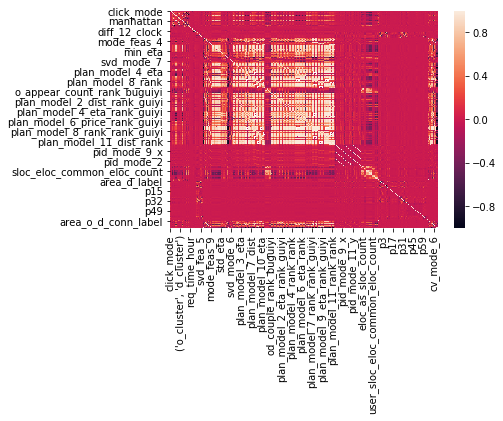

In [44]:
import seaborn 
seaborn.heatmap(data.corr())
